In [1]:
cd ~/Desktop/covid_machinations

/Users/edwardterrell/Desktop/covid_machinations


In [2]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [3]:
# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/bin/python'

In [4]:
# os, shutil used for copying/moving files
import os
import shutil
# shutil.copyfile('src', 'dst')
# shutil.move

import numpy as np
import pandas as pd
import openpyxl

In [5]:
# This code was used when repeatedly modifying date_checker module
#import importlib
#importlib.import_module('state_country_dicts') #note difference between this and reload
#importlib.reload(dc) #date_checker

In [6]:
# Custom pie_dict module contains only one function (pie) which reduces 
# the number of types into only seven basic categories for creating piecharts
from pie_dict import pie

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

from IPython.display import Image
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2021-12-30'

### The following cell determines if the Colorado site has been updated

In [8]:
# outbreaks files are updated on the web once a week usually Wed afternoon
# date_checker is a custom python module that compares the date of the
# last saved outbreak.xlsx file to the date of the outbreak.xlsx
# file on the web
import date_checker as dc

#Returns the date of the latest saved spreadsheet.
previous = dc.get_date()


# compare function outputs a tuple: url link and a date
# and prints the dates of the spreadsheets
names = dc.compare(previous)

latest saved spreadsheet is 2021-12-29
covid-19_ob_weekly_report_12_29_2021.xlsx
https://covid19.colorado.gov/sites/covid19/files/documents/covid-19_ob_weekly_report_12_29_2021.xlsx
Site NOT updated: current date of spreadsheet is 2021-12-29


In [9]:
# Examine the tuple
print (names[0])
print (names[1])

https://covid19.colorado.gov/sites/covid19/files/documents/covid-19_ob_weekly_report_12_29_2021.xlsx
2021-12-29 00:00:00


### Colorado Outbreak data

In [10]:
import urllib
import requests
import re

url = 'https://covid19.colorado.gov/data/outbreak-data'

In [11]:
!mkdir covid_data_update

In [12]:
ls covid_data_update/

In [13]:
def get_weekly_report(names):
    '''
    Opens the web page and creates a copy of the xlsx file,
    which is then archived in the directory covid_data.
    
    names is the tuple variable created by data_checker.compare()
    the two components of names are: 1) url link and 2)date in string format
    
    returns a dataframe
    '''
    link = names[0]
    response = requests.get(link)
    with open ('temp.xlsx', 'wb') as file:
        file.write(response.content)
    
    # create a permanent copy of the xlsx file in the covid_data directory
    current = names[1]
    current_report = current.strftime('%Y-%m-%d')
    shutil.copyfile('temp.xlsx', f'covid_data/covid_report_{current_report}.xlsx')
    
    df = pd.read_excel('temp.xlsx',sheet_name='Active',engine='openpyxl',parse_dates=['Date reported to public health'])
    return df

In [14]:
df = get_weekly_report(names)
df.shape

(677, 65)

In [15]:
df = df.iloc[:,:16]
df.head(3)

,Setting name,Investigation status,Date outbreak was considered closed:,COVID Setting Type,"If setting type is other, specify","Is this an At Risk Population? (Healthcare, Corrections, Highly Mobile, Schools, Critical Infrastructure)",Colorado county (exposure location),Date reported to public health,Total resident cases,Total staff cases,Total attendee cases,Total resident deaths,Total staff deaths,Total attendee deaths,Total cases,Total deaths
0,29 and One Half Road Group Home,Active,NaN,Healthcare - Group Home,NaN,Yes,Mesa,2021-12-16,5.0,4.0,NaN,NaN,NaN,NaN,9,0
1,48th Avenue - Catholic Charities Women's Shelter,Active,NaN,Homeless Shelter,NaN,Yes,Denver,2021-12-03,18.0,1.0,NaN,NaN,NaN,NaN,19,0
2,48th Avenue Center - Denver Rescue Mission,Active,NaN,Homeless Shelter,NaN,Yes,Denver,2021-08-27,106.0,2.0,NaN,NaN,NaN,NaN,108,0


In [16]:
df.shape

(677, 16)

In [17]:
def polish_report(df):
    '''polish_report removes and reorders columns and assigns shortened names. It also
    creates a datetime index, changes strings to integers and handles NaNs
    Returns: a copy of the original df
    '''
    # eliminate unnecessary columns and re-order columns
    df = df.iloc[:,[-2,0,3,6,7,8,9,10]].copy()
    
    # shorten col names for easier manipulation
    df.columns = ['total','name','type', 'county','date','residents','staff','attendee']
    
    # use the date column as the index
    df.index = df.date
    df.drop('date',axis=1, inplace=True)
    
    # replace nuisance commas
    df.name = df.name.str.replace(',','_')
    
    # fill na with 0 and turn strings to integers
    df = df.fillna(0)
    df['attendee'] = df['attendee'].astype(int) 
    df['staff'] = df['staff'].astype(int) 
    df['residents'] = df['residents'].astype(int)
    
    return df

In [18]:
current = names[1]
current_report = current.strftime('%Y-%m-%d')

In [19]:
# create dfs for both active and resolved sheets 
for i in range(2):
    i=i+1
    sheet = pd.read_excel(f'covid_data/covid_report_{current_report}.xlsx',sheet_name=i,parse_dates=['Date reported to public health'])
    sheet = sheet.iloc[:,:16]
    sheet = polish_report(sheet)
    sheet = sheet.sort_index(ascending=False)
    if i == 1: 
        df1 = sheet.resample('M').sum()
    elif i == 2: 
        df2 = sheet.resample('M').sum()

In [20]:
# Merge both dfs into a single df "totals" and change all types to integers
totals = pd.merge(df1,df2,left_index=True, right_index=True,how='outer' ).fillna(0)
totals = totals.astype(int)
totals.tail()

,total_x,residents_x,staff_x,attendee_x,total_y,residents_y,staff_y,attendee_y
date,,,,,,,,
2021-08-31,2136,560,1009,567,2051,420,815,816
2021-09-30,4802,911,779,3112,2884,772,1009,1103
2021-10-31,3180,576,758,1846,2585,885,1017,683
2021-11-30,3355,535,1111,1709,1921,338,861,722
2021-12-31,1834,325,854,655,125,41,54,30


In [21]:
# Create a column which sums active and resolved totals
totals['all_reported_cases'] = totals.total_x+totals.total_y

# Create a Date column for plotting purposes 
# Keep only the last two columns
totals['Date'] = totals.index.strftime('%Y-%m')
totals = totals.iloc[:,-2:]
totals

,all_reported_cases,Date
date,,
2020-03-31,1875,2020-03
2020-04-30,6873,2020-04
2020-05-31,2792,2020-05
2020-06-30,764,2020-06
2020-07-31,2346,2020-07
2020-08-31,1662,2020-08
2020-09-30,6408,2020-09
2020-10-31,16256,2020-10
2020-11-30,21927,2020-11


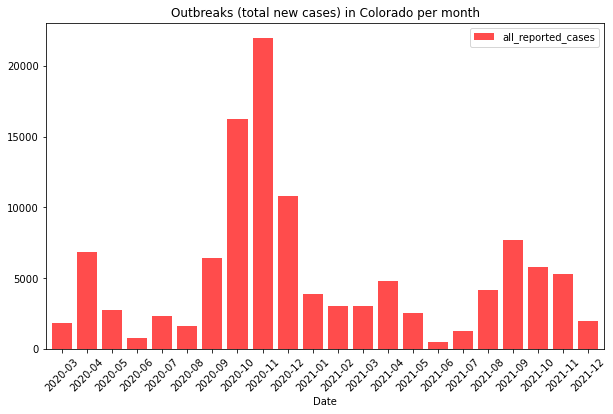

In [22]:
totals[['Date','all_reported_cases']].plot.bar(figsize=(10,6), \
                                x='Date',rot=45, width=.8, \
                                color="red",alpha=.7,\
                                title="Outbreaks (total new cases) in Colorado per month");
plt.savefig(f'./covid_data_update/outbreaks-updated-{day}.png');

### outbreaks

In [23]:
df = polish_report(df)
df = df.sort_index(ascending=False)
df.shape

(677, 7)

In [24]:
# this saves four csv files for easy viewing access even on an ipad organized by county,type, total and date
# use of f-string to allow 'day' to be interpreted correctly
df.sort_values(by='county', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-COUNTY-{day}.csv')

df.sort_values(by='type', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-TYPE-{day}.csv')

df.sort_values(by='total', inplace=True,ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-TOTAL-{day}.csv')

df =df.sort_index(ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-DATE-{day}.csv')

# total active
print(f'There are {df.shape[0]} outbreak sites and {df.total.sum()} active cases in Colorado')

There are 677 outbreak sites and 19500 active cases in Colorado


In [25]:
# Future modification planned to show data across year boundaries
# dfy is the df for the current year
dfy = df[df.index.year==today.year].copy()

In [26]:
# df_month is the df for the selected month
df_month = dfy[dfy.index.month==today.month].copy()

In [27]:
df_month

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-12-29,5,Boulder Bridge House: December 2021,Homeless Shelter,Boulder,5,0,0
2021-12-29,2,Villa Manor Care Center (020451): December 2021,Healthcare - Skilled Nursing,Jefferson,0,2,0
2021-12-28,8,The Goddard School of Denver - City Park West:...,Child Care Center,Denver,0,4,4
2021-12-28,6,Centaurus High School: December 2021,School K-12,Boulder,0,1,5
2021-12-28,6,St Andrews Village-LTC (02O244): December 2021,Healthcare - Skilled Nursing,Arapahoe,5,1,0
...,...,...,...,...,...,...,...
2021-12-01,9,North Star Rehabilitation and Care Community (...,Healthcare - Skilled Nursing,Denver,5,4,0
2021-12-01,5,Holly Heights Care Center (020412): November 2021,Healthcare - Skilled Nursing,Denver,0,5,0
2021-12-01,10,The Center at Lowry (02G500): November 2021,Healthcare - Skilled Nursing,Denver,0,10,0


In [28]:
df_month.total.sum()

1834

In [29]:
#df_month.reset_index(inplace=True)
df_month = df_month[['total','name','type','county']]
df_month

,total,name,type,county
date,,,,
2021-12-29,5,Boulder Bridge House: December 2021,Homeless Shelter,Boulder
2021-12-29,2,Villa Manor Care Center (020451): December 2021,Healthcare - Skilled Nursing,Jefferson
2021-12-28,8,The Goddard School of Denver - City Park West:...,Child Care Center,Denver
2021-12-28,6,Centaurus High School: December 2021,School K-12,Boulder
2021-12-28,6,St Andrews Village-LTC (02O244): December 2021,Healthcare - Skilled Nursing,Arapahoe
...,...,...,...,...
2021-12-01,9,North Star Rehabilitation and Care Community (...,Healthcare - Skilled Nursing,Denver
2021-12-01,5,Holly Heights Care Center (020412): November 2021,Healthcare - Skilled Nursing,Denver
2021-12-01,10,The Center at Lowry (02G500): November 2021,Healthcare - Skilled Nursing,Denver


In [30]:
# get number of sites and total cases for the month
s_num = df_month.shape[0]-1
t = df_month.total.sum()
print(f'There were an additional {s_num} outbreak sites in Colorado this month.')
print (f'These represent a total of {t} new cases.')

There were an additional 211 outbreak sites in Colorado this month.
These represent a total of 1834 new cases.


In [31]:
# list all active cases in Boulder County
boulder = df[df.county=='Boulder']
bc = boulder.total.sum()
print(f'There are {bc} active cases in Boulder County')

There are 456 active cases in Boulder County


In [32]:
boulder = boulder.sort_index(ascending=False)
boulder.to_csv(f'./covid_data_update/boulder-{day}.csv')
boulder

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-12-29,5,Boulder Bridge House: December 2021,Homeless Shelter,Boulder,5,0,0
2021-12-28,6,Centaurus High School: December 2021,School K-12,Boulder,0,1,5
2021-12-28,3,PowerBack Rehabilitation Lafayette (02U713): D...,Healthcare - Skilled Nursing,Boulder,2,1,0
2021-12-28,6,Flatirons Health and Rehab (02H512): December ...,Healthcare - Skilled Nursing,Boulder,2,4,0
2021-12-28,2,Golden West (230379): December 2021,Healthcare - Assisted Living,Boulder,1,1,0
2021-12-27,10,Southern Sun Pub and Brewery,Bar/Tavern/Brewery,Boulder,0,10,0
2021-12-27,14,Left Hand Brewing Company,Bar/Tavern/Brewery,Boulder,0,14,0
2021-12-26,8,BDT Stage,Indoor Entertainment/Rec,Boulder,0,4,4
2021-12-22,8,Encore Electric_ Inc - Longmont,Construction Site,Boulder,0,8,0


### Create Pie Chart

In [33]:
# total number of active cases
s = df.total.sum()
s

19500

In [34]:
# list of major types by percent of total
df_percent = df.groupby('type').total.sum()/s
print (f'These represent {df_percent[df_percent > .01].sum()*100:.0f}% of all outbreak cases')
df_percent[df_percent > .01]

These represent 91% of all outbreak cases


type
Child Care Center                           0.019744
College/University                          0.035538
Construction Company/Contractor             0.018872
Distribution Center/Business                0.030000
Healthcare - Assisted Living                0.020821
Healthcare - Independent Living Facility    0.011077
Healthcare - Psychiatric Hospital           0.012821
Healthcare - Skilled Nursing                0.046974
Homeless Shelter                            0.016410
Hotel/Lodge/Resort                          0.020410
Jail                                        0.172205
Office/Indoor Workspace                     0.029949
Other                                       0.018615
Retailer                                    0.013333
School K-12                                 0.423333
State Prison                                0.015538
Name: total, dtype: float64

In [35]:
# custom function from pie_dict 
from pie_dict import pie

In [36]:
df_pie = pie (df)
df_pie.head()
pie_list = np.array(['College/University', 'Jail/Prison', 'Other',
       'Office/Mfg/Dist/Construction', 'Healthcare', 'Resturant/Retail',
       'Day Care/School'], dtype=object)

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-12-29,5,Boulder Bridge House: December 2021,Other,Boulder,5,0,0
2021-12-29,2,Villa Manor Care Center (020451): December 2021,Healthcare,Jefferson,0,2,0
2021-12-28,8,The Goddard School of Denver - City Park West:...,Day Care/School,Denver,0,4,4
2021-12-28,6,Centaurus High School: December 2021,Day Care/School,Boulder,0,1,5
2021-12-28,6,St Andrews Village-LTC (02O244): December 2021,Healthcare,Arapahoe,5,1,0


In [37]:
'''test = df.type.unique()
test = np.append(test,['Social Gathering','Travel'])
len(test)
'''

"test = df.type.unique()\ntest = np.append(test,['Social Gathering','Travel'])\nlen(test)\n"

In [38]:
df.type.unique()

array(['Other', 'Healthcare', 'Day Care/School', 'Resturant/Retail',
       'Municipal/Local Government', 'Office/Mfg/Dist/Construction',
       'Jail/Prison', 'College/University'], dtype=object)

In [39]:
def check_types(df):
    '''check_types checks to see if any new categories were added and 
    if so reassigns them to the Other category
    Returns: a copy of the original df
    '''
    test = df.type.unique()
    if len(test) != 7:
        more_types = [item for item in test if item not in pie_list]
        df.type = df.type.replace(dict.fromkeys(more_types, 'Other'))
        print(f'{more_types} were added to the category: Other')
    else:
        print('No new types were added to the category: Other')
        
    return df

In [40]:
df = check_types(df)

['Municipal/Local Government'] were added to the category: Other


In [41]:
df.total = df.total.astype(int)

p = df.groupby('type').total.sum()
print (p)
total_cases = p.sum()
total_cases

type
College/University               693
Day Care/School                 8698
Healthcare                      2134
Jail/Prison                     3820
Office/Mfg/Dist/Construction    1985
Other                           1476
Resturant/Retail                 694
Name: total, dtype: int64


19500

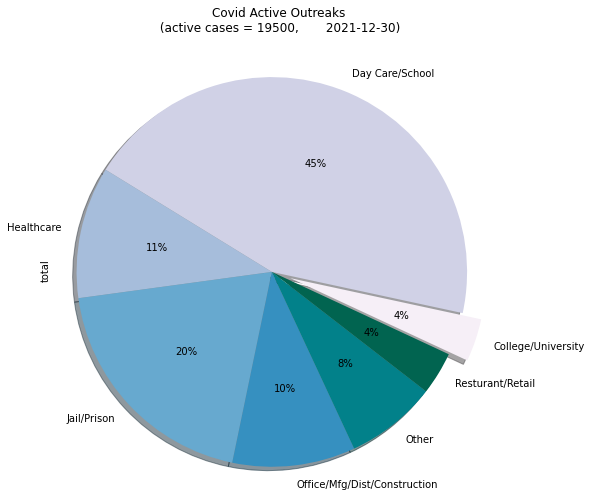

In [42]:
# creates a pie chart of the current total active cases
my_colors = ['#f6eff7','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016450']

explode = (.1,0,0,0,0,0,0)

p.plot.pie(figsize=(8,8),explode=explode,autopct='%1.0f%%',
        shadow=True, colors=my_colors,startangle=-25);
plt.title(f'Covid Active Outreaks\n (active cases = {total_cases},       {day})\n')

plt.axis('equal')
plt.savefig(f'./covid_data_update/outbreaks-piechart-{day}.png');

In [43]:
#cd covid_data_update

In [44]:
# Gathering summary statistics for a two month pie chart 
# create datetime and integers types 
this_month = pd.read_csv(f'covid_data_update/outbreaks-DATE-{day}.csv')
this_month.date = pd.to_datetime(this_month.date)
this_month.total = this_month.total.astype(int)

In [45]:
# apply custom pie function
this_month = pie(this_month)

In [46]:
# Create string variables for the first day of the previous month and previous month
start = today - pd.offsets.MonthBegin (2)
str_date = start.strftime('%Y-%m-%d')
str_date
month = start.strftime('%B')
month

'2021-11-01'

'November'

In [47]:
#set filter to start month (month always starts on the first)
#check for new types
start_month = this_month[this_month.date > str_date].copy()
start_month = check_types(start_month)

['Municipal/Local Government'] were added to the category: Other


In [48]:
start_month = start_month.groupby('type').total.sum()
this_month_cases = start_month.sum()
start_month

type
College/University               137
Day Care/School                 2375
Healthcare                      1097
Jail/Prison                      439
Office/Mfg/Dist/Construction     439
Other                            339
Resturant/Retail                 158
Name: total, dtype: int64

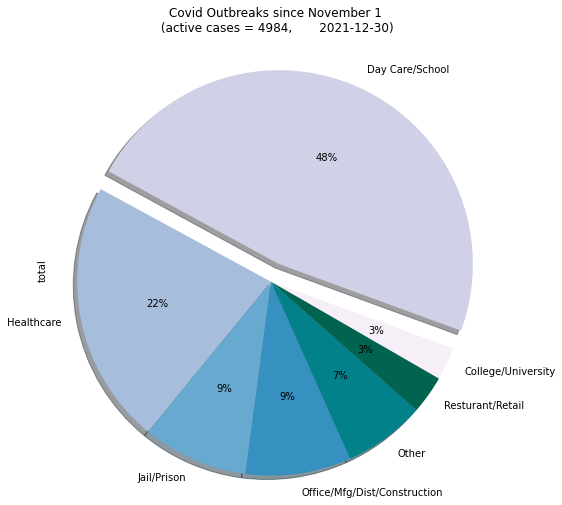

In [49]:
# creates a pie chart 
my_colors = ['#f6eff7','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016450']

explode = (0,.1,0,0,0,0,0)

start_month.plot.pie(figsize=(8,8),explode=explode,autopct='%1.0f%%', 
             shadow=True, colors=my_colors,startangle=-30)

plt.title(f'Covid Outbreaks since {month} 1\n (active cases = {this_month_cases},       {day})\n')

plt.axis('equal')
plt.savefig(f'covid_data_update/this_month_outbreaks-piechart-{day}.png');

### Displays all updated graphs files

In [50]:
!ls -t1 covid_data_update | head -n 20 | grep -ve '^bolder' -ve 'png$' -ve 'xlsx$' > covid_text
!ls covid_data_update/*.png > flist_of_covid_png 

['covid_data_update/outbreaks-piechart-2021-12-30.png',
 'covid_data_update/outbreaks-updated-2021-12-30.png',
 'covid_data_update/this_month_outbreaks-piechart-2021-12-30.png']

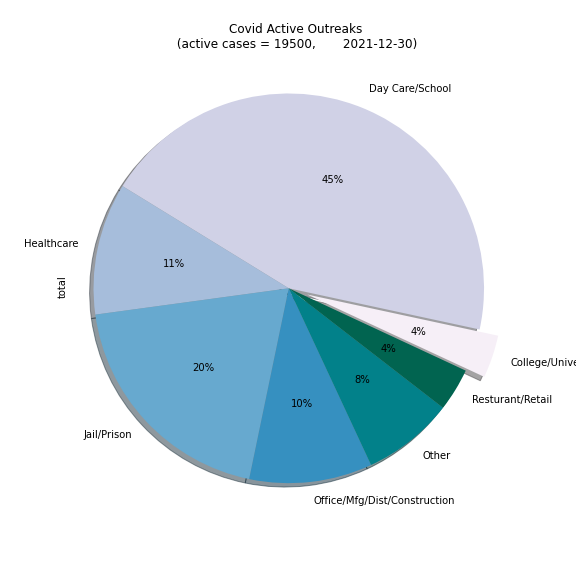

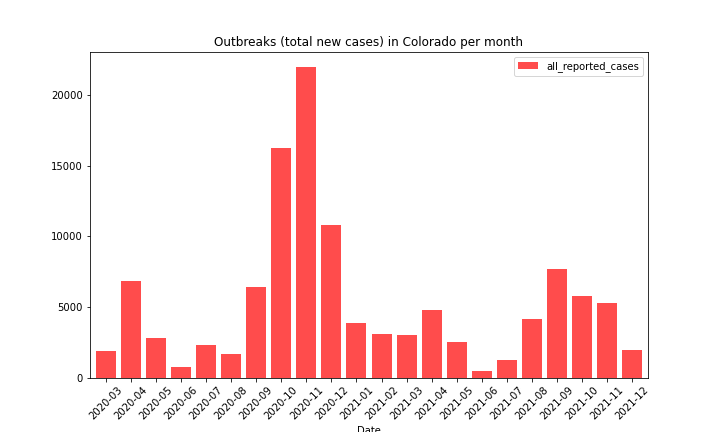

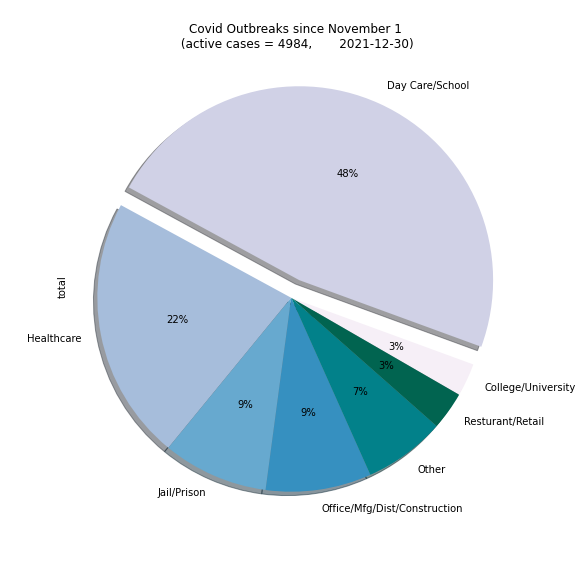

In [51]:
# Loop through the file flist and store filenames in png_list
with open('flist_of_covid_png') as f:
    png_str = f.read()
png_list = png_str.split('\n')[0:-1]

png_list

from IPython.display import Image

for file in png_list:    
    local = Image(file)
    local
    

In [52]:
    
# These were helper files and are not needed any longer
!rm -f covid_text
!rm -f flist_of_covid_png
!rm -f temp.xlsx

### More Detailed Inquiry

In [ ]:
# create dfs for both active and resolved sheets 
for i in range(2):
    i=i+1
    #df = pd.read_excel(f'covid_data/covid_report_{current_report}.xlsx',sheet_name=i,parse_dates=['Date reported to public health'])
    df = pd.read_excel('~/Desktop/covid-19-data/covid_data/covid_report_2021-12-22.xlsx',sheet_name=i,parse_dates=['Date reported to public health'])
    df = df.iloc[:,:16]
    df = polish_report(df)
    
    
    df = df.sort_index(ascending=False)
    if i == 1: 
        active = df
    elif i == 2: 
        resolved = df

In [ ]:
pd.options.display.max_rows = 300
pd.options.display.min_rows = 200

#### Select start and stop dates:

In [ ]:
# Default conditions are set in module date_select
# Default start/stop is 2021-10-01 to 2021-10-31.
# Custom stop date, default is today

In [ ]:
import date_select as ds
start,stop = ds.date_maker()

### tabla rasa

In [54]:
!ls covid_data_update

boulder-2021-12-30.csv
outbreaks-COUNTY-2021-12-30.csv
outbreaks-DATE-2021-12-30.csv
outbreaks-TOTAL-2021-12-30.csv
outbreaks-TYPE-2021-12-30.csv
outbreaks-piechart-2021-12-30.png
outbreaks-updated-2021-12-30.png
this_month_outbreaks-piechart-2021-12-30.png


In [ ]:
!rm -rf covid_data_update